In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from utils.datasets import get_mnist, get_images_for_class, generate_mean_image_for_class, get_random_image
from utils.utils import show_examples, imshow, show_neighbors, show_dataset_examples
from utils.models import SeparableCNN, DeConvNet
from utils.train import train_separable_cnn, save, validate_separable_cnn, load

In [2]:
model_name = 'model_feature_evolution.pt'

# I. Feature Evolution during Training

## 1. Load and display the dataset

In [18]:
trainset, trainloader, testset, testloader = get_mnist()

    2     3     2     7


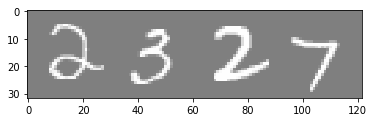

In [19]:
show_dataset_examples(trainloader)

## 2. Create the model

In [20]:
model = SeparableCNN()
print(model)

SeparableCNN(
  (base): CNNBase(
    (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): CNNClassifier(
    (fc1): Linear(in_features=320, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
  )
)


## 3. Train and validate the model

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
def run_deconv(model, deconv_model, image, show=True):
    x, first_idxs, second_idxs = model.base(image)

    result = deconv_model(x, second_idxs, first_idxs)
    
    # Normalize photo
    result = result.detach()
    result = (result - result.min()) / (result.max() - result.min())
    image = (image - image.min()) / (image.max() - image.min())
    
    if show:
        images = torch.zeros((2, 1, 28, 28))
        images[0] = image
        images[1] = result.detach()

        imshow(torchvision.utils.make_grid(images))
    
    return result

In [23]:
def show_feature_maps(model, img):
    deconv_model = DeConvNet()

    # Load the weights from the trained base model
    deconv_model.deconv1.weight = model.base.conv2.weight
    deconv_model.deconv2.weight = model.base.conv1.weight

    # Plot the results by iteratively setting all but one filters from
    # the first CONV layer to zero.
    first_weights = model.base.conv1.weight
    images = torch.zeros(10, 1, 28, 28)
    for i in range(10):
        new_weights = torch.zeros(first_weights.size())
        new_weights[i] = model.base.conv1.weight[i]
        deconv_model.deconv2.weight = torch.nn.Parameter(new_weights)

        images[i] = run_deconv(model, deconv_model, img, False)

    print("Results for the first CONV layer")
    show_examples(images)

    # Plot the results by iteratively setting all but one filters from
    # the second CONV layer to zero.
    deconv_model.deconv2.weight = model.base.conv1.weight
    second_weights = model.base.conv2.weight
    images = torch.zeros(20, 1, 28, 28)
    for i in range(20):
        new_weights = torch.zeros(second_weights.size())
        new_weights[i] = model.base.conv2.weight[i]
        deconv_model.deconv1.weight = torch.nn.Parameter(new_weights)

        images[i] = run_deconv(model, deconv_model, img, False)

    print("Results for the second CONV layer")
    show_examples(images)

In [24]:
def train_separable_cnn_with_feature_evolution(model, criterion, optimizer, trainloader, base_image, epochs=5):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs.requires_grad = True
            optimizer.zero_grad()

            outputs, _, _ = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 300 == 299 or i == len(trainloader) - 1:
                _, predicted = torch.max(outputs.data, 1)
                total = labels.size(0)

                accuracy = (predicted == labels).sum().item() / total
                loss = running_loss / total

                print('Epoch: %d\tBatch: %d\tLoss: %.3f\tAccuracy: %.3f' %
                      (epoch + 1, i + 1, loss, accuracy))
                running_loss = 0.0
        print(f'Feature maps after {epoch + 1}th epoch.')
        show_feature_maps(model, base_image)
        print('##########################################')

    print('Finished Training')


Base Image:


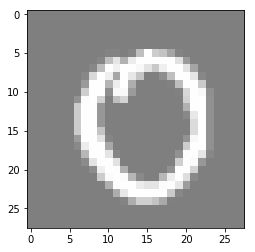

In [28]:
base_image, _ = get_random_image(trainloader)

print("Base Image:")
show_examples(base_image)

Epoch: 1	Batch: 300	Loss: 1.432	Accuracy: 0.922
Epoch: 1	Batch: 600	Loss: 0.463	Accuracy: 0.938
Epoch: 1	Batch: 900	Loss: 0.389	Accuracy: 0.969
Epoch: 1	Batch: 938	Loss: 0.099	Accuracy: 0.969
Feature maps after 1th epoch.
Results for the first CONV layer


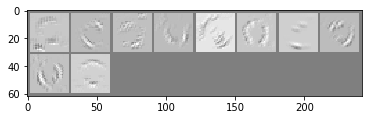

Results for the second CONV layer


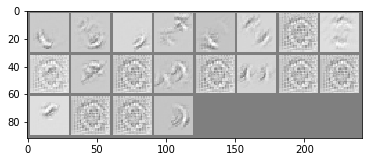

##########################################
Epoch: 2	Batch: 300	Loss: 0.356	Accuracy: 0.984
Epoch: 2	Batch: 600	Loss: 0.382	Accuracy: 0.953
Epoch: 2	Batch: 900	Loss: 0.335	Accuracy: 0.984
Epoch: 2	Batch: 938	Loss: 0.082	Accuracy: 0.969
Feature maps after 2th epoch.
Results for the first CONV layer


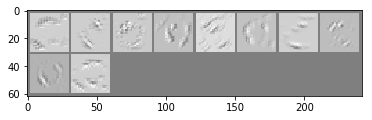

Results for the second CONV layer


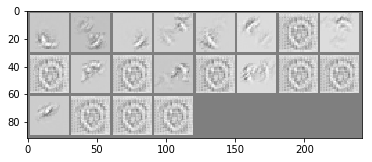

##########################################
Epoch: 3	Batch: 300	Loss: 0.302	Accuracy: 0.984
Epoch: 3	Batch: 600	Loss: 0.265	Accuracy: 1.000
Epoch: 3	Batch: 900	Loss: 0.315	Accuracy: 0.984
Epoch: 3	Batch: 938	Loss: 0.115	Accuracy: 1.000
Feature maps after 3th epoch.
Results for the first CONV layer


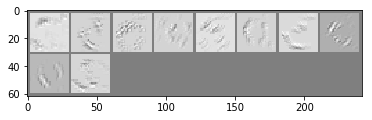

Results for the second CONV layer


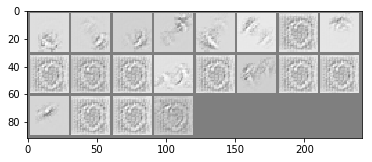

##########################################
Epoch: 4	Batch: 300	Loss: 0.243	Accuracy: 1.000
Epoch: 4	Batch: 600	Loss: 0.251	Accuracy: 0.969
Epoch: 4	Batch: 900	Loss: 0.314	Accuracy: 1.000
Epoch: 4	Batch: 938	Loss: 0.101	Accuracy: 0.938
Feature maps after 4th epoch.
Results for the first CONV layer


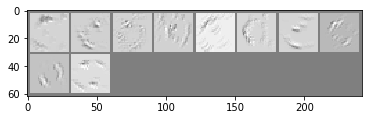

Results for the second CONV layer


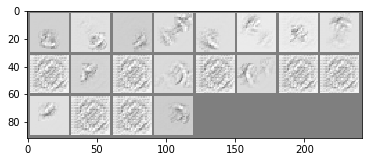

##########################################
Epoch: 5	Batch: 300	Loss: 0.244	Accuracy: 0.938
Epoch: 5	Batch: 600	Loss: 0.259	Accuracy: 1.000
Epoch: 5	Batch: 900	Loss: 0.276	Accuracy: 1.000
Epoch: 5	Batch: 938	Loss: 0.049	Accuracy: 1.000
Feature maps after 5th epoch.
Results for the first CONV layer


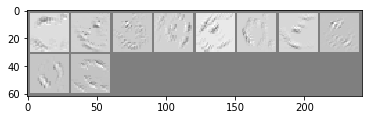

Results for the second CONV layer


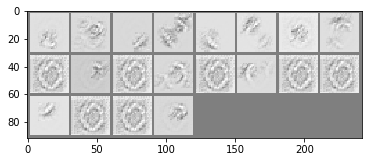

##########################################
Finished Training


In [29]:
train_separable_cnn_with_feature_evolution(model, criterion, optimizer, trainloader, base_image, 5)

In [30]:
validate_separable_cnn(model, criterion, testloader)

Test loss: 0.045


## 4. Save the model

In [ ]:
save(model, model_name)